# Using pre-trained word embeddings and rnn\cnn for text clasification

Highly adapted from [here](https://keras.io/examples/nlp/pretrained_word_embeddings/)



## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

2023-05-09 09:29:10.267241: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-09 09:29:10.320938: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-09 09:29:10.654041: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-09 09:29:10.656254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 09:29:12.540260: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Introduction

In this example, we show how to train a text classification model that uses pre-trained
word embeddings.

We'll work with the Newsgroup20 dataset, a set of 20,000 message board messages
belonging to 20 different topic categories.

For the pre-trained word embeddings, we'll use
[GloVe embeddings](http://nlp.stanford.edu/projects/glove/).

## Download the Newsgroup20 data

In [2]:
data_path = keras.utils.get_file(
    "news20.tar.gz",
    "http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.tar.gz",
    untar=True,
)

## Let's take a look at the data

In [3]:
import os
import pathlib

data_dir = pathlib.Path(data_path).parent / "20_newsgroup"
dirnames = os.listdir(data_dir)
print("Number of directories:", len(dirnames))
print("Directory names:", dirnames)

fnames = os.listdir(data_dir / "comp.graphics")
print("Number of files in comp.graphics:", len(fnames))
print("Some example filenames:", fnames[:5])

Number of directories: 20
Directory names: ['alt.atheism', 'comp.windows.x', 'rec.motorcycles', 'soc.religion.christian', 'rec.sport.baseball', 'rec.autos', 'sci.crypt', 'comp.sys.ibm.pc.hardware', 'talk.politics.misc', 'talk.politics.mideast', 'sci.med', 'sci.space', 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware', 'talk.politics.guns', 'talk.religion.misc', 'sci.electronics', 'comp.graphics', 'misc.forsale', 'rec.sport.hockey']
Number of files in comp.graphics: 1000
Some example filenames: ['38544', '38562', '38404', '38530', '38835']


Here's a example of what one file contains:

In [4]:
print(open(data_dir / "comp.graphics" / "38987").read())

Newsgroups: comp.graphics
Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!agate!dog.ee.lbl.gov!network.ucsd.edu!usc!rpi!nason110.its.rpi.edu!mabusj
From: mabusj@nason110.its.rpi.edu (Jasen M. Mabus)
Subject: Looking for Brain in CAD
Message-ID: <c285m+p@rpi.edu>
Nntp-Posting-Host: nason110.its.rpi.edu
Reply-To: mabusj@rpi.edu
Organization: Rensselaer Polytechnic Institute, Troy, NY.
Date: Thu, 29 Apr 1993 23:27:20 GMT
Lines: 7

Jasen Mabus
RPI student

	I am looking for a hman brain in any CAD (.dxf,.cad,.iges,.cgm,etc.) or picture (.gif,.jpg,.ras,etc.) format for an animation demonstration. If any has or knows of a location please reply by e-mail to mabusj@rpi.edu.

Thank you in advance,
Jasen Mabus  



As you can see, there are header lines that are leaking the file's category, either
explicitly (the first line is literally the category name), or implicitly, e.g. via the
`Organization` filed. Let's get rid of the headers:

In [5]:
samples = []
labels = []
class_names = []
class_index = 0
for dirname in sorted(os.listdir(data_dir)):
    class_names.append(dirname)
    dirpath = data_dir / dirname
    fnames = os.listdir(dirpath)
    print("Processing %s, %d files found" % (dirname, len(fnames)))
    for fname in fnames:
        fpath = dirpath / fname
        f = open(fpath, encoding="latin-1")
        content = f.read()
        lines = content.split("\n")
        lines = lines[10:]
        content = "\n".join(lines)
        samples.append(content)
        labels.append(class_index)
    class_index += 1

print("Classes:", class_names)
print("Number of samples:", len(samples))

Processing alt.atheism, 1000 files found
Processing comp.graphics, 1000 files found
Processing comp.os.ms-windows.misc, 1000 files found
Processing comp.sys.ibm.pc.hardware, 1000 files found
Processing comp.sys.mac.hardware, 1000 files found
Processing comp.windows.x, 1000 files found
Processing misc.forsale, 1000 files found
Processing rec.autos, 1000 files found
Processing rec.motorcycles, 1000 files found
Processing rec.sport.baseball, 1000 files found
Processing rec.sport.hockey, 1000 files found
Processing sci.crypt, 1000 files found
Processing sci.electronics, 1000 files found
Processing sci.med, 1000 files found
Processing sci.space, 1000 files found
Processing soc.religion.christian, 997 files found
Processing talk.politics.guns, 1000 files found
Processing talk.politics.mideast, 1000 files found
Processing talk.politics.misc, 1000 files found
Processing talk.religion.misc, 1000 files found
Classes: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.ha

There's actually one category that doesn't have the expected number of files, but the
difference is small enough that the problem remains a balanced classification problem.

## Shuffle and split the data into training & validation sets

In [6]:
# Shuffle the data
seed = 1337
rng = np.random.RandomState(seed)
rng.shuffle(samples)
rng = np.random.RandomState(seed)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
val_samples = samples[-num_validation_samples:]
train_labels = labels[:-num_validation_samples]
val_labels = labels[-num_validation_samples:]

## Create a vocabulary index

Let's use the `TextVectorization` to index the vocabulary found in the dataset.
Later, we'll use the same layer instance to vectorize the samples.

Our layer will only consider the top 20,000 words, and will truncate or pad sequences to
be actually 200 tokens long.

In [7]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

2023-05-09 09:29:46.186352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [15998]
	 [[{{node Placeholder/_0}}]]


You can retrieve the computed vocabulary used via `vectorizer.get_vocabulary()`. Let's
print the top 5 words:

In [8]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'to', 'of']

Let's vectorize a test sentence:

In [9]:
output = vectorizer([["the cat sat on the mat"]])
output.numpy()[0, :6]

array([   2, 3595, 1719,   15,    2, 6134])

As you can see, "the" gets represented as "2". Why not 0, given that "the" was the first
word in the vocabulary? That's because index 0 is reserved for padding and index 1 is
reserved for "out of vocabulary" tokens.

Here's a dict mapping words to their indices:

In [10]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

As you can see, we obtain the same encoding as above for our test sentence:

In [11]:
test = ["the", "cat", "sat", "on", "the", "mat"]
[word_index[w] for w in test]

[2, 3595, 1719, 15, 2, 6134]

## Load pre-trained word embeddings

In [12]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

The archive contains text-encoded vectors of various sizes: 50-dimensional,
100-dimensional, 200-dimensional, 300-dimensional. We'll use the 50D ones.

Let's make a dict mapping words (strings) to their NumPy vector representation:

In [13]:
glove_dir =  ''

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


### Now, let's prepare a corresponding embedding matrix that we can use in a Keras `Embedding` layer.
### It's a simple NumPy matrix where entry at index `i` is the pre-trained vector for the word of index `i` in our `vectorizer`'s vocabulary.

In [14]:
num_tokens = len(voc) + 2
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 17983 words (2017 misses)


### Or use a random embedding matrix instead of the pretrained embedding matrix
### Note the difference in terms of performance and training time. Why?
hint: Start training from scratch

In [15]:
random_matrix = np.random.normal(loc=0, scale=1, size=(num_tokens, embedding_dim))

## Build the models: We will build both cnn and rnn models

### We start by a simple 1D convnet with global max pooling and a classifier at the end.

###and ... Yes! 1d-cnn can be used for text processing the same way a 2d-cnn is used for images


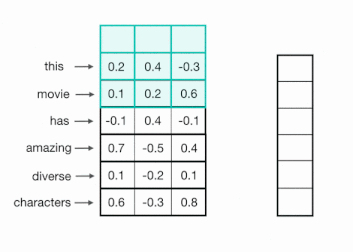

### We define an embedding layer and plug here either the pretrained "embedding_matrix" or the "random_matrix".
### Note that we set `trainable=False` so as to keep the embeddings fixed (we don't want to update them during training). If  we use the random embeding (not pretrained) we set `trainable=True`


In [16]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    #plug here either the pretrained "embedding_matrix" or the "randomm_matrix"
    #embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    embeddings_initializer=keras.initializers.Constant(random_matrix),
    trainable=True,
)

In [17]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 50)          1000100   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         32128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 128)        0         
 1D)                                                         

## Train the model

First, convert our list-of-strings data to NumPy arrays of integer indices. The arrays
are right-padded.

In [18]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

We use categorical crossentropy as our loss since we're doing softmax classification.
Moreover, we use `sparse_categorical_crossentropy` since our labels are integers.

In [19]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)
model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
125/125 [==============================] - 14s 100ms/step - loss: 2.9895 - acc: 0.0688 - val_loss: 2.9356 - val_acc: 0.0793
Epoch 2/20
125/125 [==============================] - 12s 98ms/step - loss: 2.9156 - acc: 0.0867 - val_loss: 2.8262 - val_acc: 0.1145
Epoch 3/20
125/125 [==============================] - 12s 96ms/step - loss: 2.8229 - acc: 0.1023 - val_loss: 2.7236 - val_acc: 0.1125
Epoch 4/20
125/125 [==============================] - 12s 93ms/step - loss: 2.7239 - acc: 0.1201 - val_loss: 2.6164 - val_acc: 0.1500
Epoch 5/20
125/125 [==============================] - 12s 94ms/step - loss: 2.6165 - acc: 0.1506 - val_loss: 2.6636 - val_acc: 0.1290
Epoch 6/20
125/125 [==============================] - 12s 94ms/step - loss: 2.5243 - acc: 0.1629 - val_loss: 2.5472 - val_acc: 0.1618
Epoch 7/20
125/125 [==============================] - 12s 94ms/step - loss: 2.4203 - acc: 0.1942 - val_loss: 2.5455 - val_acc: 0.1720
Epoch 8/20
125/125 [==============================] - 12s 93m

Next, we load the pre-trained word embeddings matrix into an `Embedding` layer,
set `trainable=True or False` and rebuild the model

In [20]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [21]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 50)          1000100   
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         32128     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 128)        0         
 1D)                                                       

In [22]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)
model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
125/125 [==============================] - 12s 83ms/step - loss: 2.6299 - acc: 0.1445 - val_loss: 2.0397 - val_acc: 0.3093
Epoch 2/10
125/125 [==============================] - 10s 80ms/step - loss: 1.9374 - acc: 0.3289 - val_loss: 1.6584 - val_acc: 0.4149
Epoch 3/10
125/125 [==============================] - 10s 82ms/step - loss: 1.5979 - acc: 0.4507 - val_loss: 1.4484 - val_acc: 0.4939
Epoch 4/10
125/125 [==============================] - 10s 81ms/step - loss: 1.3816 - acc: 0.5241 - val_loss: 1.3498 - val_acc: 0.5466
Epoch 5/10
125/125 [==============================] - 10s 83ms/step - loss: 1.2292 - acc: 0.5751 - val_loss: 1.2584 - val_acc: 0.5661
Epoch 6/10
125/125 [==============================] - 10s 83ms/step - loss: 1.1023 - acc: 0.6250 - val_loss: 1.1830 - val_acc: 0.5884
Epoch 7/10
125/125 [==============================] - 10s 83ms/step - loss: 0.9967 - acc: 0.6551 - val_loss: 1.1169 - val_acc: 0.6282
Epoch 8/10
125/125 [==============================] - 10s 83ms

## Export an end-to-end model

Now, we may want to export a `Model` object that takes as input a string of arbitrary
length, rather than a sequence of indices. It would make the model much more portable,
since you wouldn't have to worry about the input preprocessing pipeline.

Our `vectorizer` is actually a Keras layer, so it's simple:

In [23]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict(
    [["this message is about computer graphics and 3D modeling"]]
)

class_names[np.argmax(probabilities[0])]

1/1 [==============================] - 1s 505ms/step


'comp.graphics'

# Now try a recursive network (e.g. lstm) model instead of the cnn
(much more slowly)


In [24]:
int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)

# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(embedded_sequences)
x = layers.Bidirectional(layers.LSTM(64))(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

2023-05-09 09:38:09.949407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 09:38:09.952956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 09:38:09.955037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 50)          1000100   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        58880     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 20)                2580      
                                                                 
Total params: 1,160,376
Trainable params: 160,276
Non-train

2023-05-09 09:38:10.943421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-05-09 09:38:11.031508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 09:38:11.034090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

In [25]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)
model.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_val, y_val))

Epoch 1/5


2023-05-09 09:38:11.664575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 09:38:11.668963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 09:38:11.672370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

125/125 [==============================] - ETA: 0s - loss: 2.4673 - acc: 0.2005

2023-05-09 09:39:23.029231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 09:39:23.031885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 09:39:23.033746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

125/125 [==============================] - 80s 567ms/step - loss: 2.4673 - acc: 0.2005 - val_loss: 2.0739 - val_acc: 0.3018
Epoch 2/5
125/125 [==============================] - 63s 508ms/step - loss: 2.0130 - acc: 0.3232 - val_loss: 1.8558 - val_acc: 0.3606
Epoch 3/5
125/125 [==============================] - 61s 492ms/step - loss: 1.7901 - acc: 0.3913 - val_loss: 1.9192 - val_acc: 0.3458
Epoch 4/5
125/125 [==============================] - 66s 526ms/step - loss: 1.6877 - acc: 0.4246 - val_loss: 1.6266 - val_acc: 0.4359
Epoch 5/5
125/125 [==============================] - 65s 517ms/step - loss: 1.5584 - acc: 0.4709 - val_loss: 1.6408 - val_acc: 0.4591


## HW: try with random/pre-trained embeddings; trainable = True/False, larger embedding dims, CNN/RNN; etc. 

Lets try to expand the embedding dimensions to 200, and expand the second hidden layer of the model to 128, as well as add a second Fully connected layer.

In [13]:
glove_dir =  ''

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [14]:
num_tokens = len(voc) + 2
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)


Converted 17983 words (2017 misses)


In [15]:
x_train = vectorizer(np.array([[s] for s in train_samples]))
x_val = vectorizer(np.array([[s] for s in val_samples]))

y_train = np.array(train_labels)
y_val = np.array(val_labels)

In [23]:
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, LSTM
from tensorflow.keras.optimizers import Adam

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)

# Add 2 bidirectional LSTMs
x = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)
x = Bidirectional(LSTM(128))(x)
x = Dense(1024, activation="sigmoid")(x)
preds = Dense(len(class_names), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

model.compile(
    loss="sparse_categorical_crossentropy", optimizer=Adam(0.001), metrics=["acc"]
)
model.fit(x_train, y_train, batch_size=64, epochs=7, validation_data=(x_val, y_val))

2023-05-08 20:25:44.151374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 20:25:44.155559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 20:25:44.158526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_5 (Embedding)     (None, None, 200)         4000400   
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 128)        135680    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 1024)              263168    
                                                                 
 dense_6 (Dense)             (None, 20)                2050

2023-05-08 20:25:45.405735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-05-08 20:25:45.497107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 20:25:45.500440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

Trainable params: 682,516
Non-trainable params: 4,000,400
_________________________________________________________________
Epoch 1/7


2023-05-08 20:25:46.120769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 20:25:46.124033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 20:25:46.126145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

250/250 [==============================] - ETA: 0s - loss: 2.4149 - acc: 0.1891

2023-05-08 20:28:31.736310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 20:28:31.738738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 20:28:31.740692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

250/250 [==============================] - 180s 671ms/step - loss: 2.4149 - acc: 0.1891 - val_loss: 2.0248 - val_acc: 0.2761
Epoch 2/7
250/250 [==============================] - 182s 728ms/step - loss: 1.8584 - acc: 0.3322 - val_loss: 1.7474 - val_acc: 0.3806
Epoch 3/7
250/250 [==============================] - 161s 646ms/step - loss: 1.4946 - acc: 0.4602 - val_loss: 1.4262 - val_acc: 0.4849
Epoch 4/7
250/250 [==============================] - 167s 670ms/step - loss: 1.2534 - acc: 0.5555 - val_loss: 1.2117 - val_acc: 0.5676
Epoch 5/7
250/250 [==============================] - 145s 580ms/step - loss: 1.1116 - acc: 0.6085 - val_loss: 1.1288 - val_acc: 0.6079
Epoch 6/7
250/250 [==============================] - 148s 592ms/step - loss: 0.9742 - acc: 0.6570 - val_loss: 1.0872 - val_acc: 0.6449
Epoch 7/7
250/250 [==============================] - 153s 611ms/step - loss: 0.8617 - acc: 0.7075 - val_loss: 1.0175 - val_acc: 0.6639


Not much of an improvement.

Lets try running the same thing, but this time just setting trainable=True for the pre-trained embeddings.

In [24]:
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, LSTM
from tensorflow.keras.optimizers import Adam

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=True,
)

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)

# Add 2 bidirectional LSTMs
x = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)
x = Bidirectional(LSTM(128))(x)
x = Dense(1024, activation="sigmoid")(x)
preds = Dense(len(class_names), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

model.compile(
    loss="sparse_categorical_crossentropy", optimizer=Adam(0.001), metrics=["acc"]
)
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))

2023-05-08 20:47:41.252809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 20:47:41.258511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 20:47:41.260842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_6 (Embedding)     (None, None, 200)         4000400   
                                                                 
 bidirectional_8 (Bidirectio  (None, None, 128)        135680    


2023-05-08 20:47:42.446322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-05-08 20:47:42.545072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 20:47:42.547706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 1024)              263168    
                                                                 
 dense_8 (Dense)             (None, 20)                20500     
                                                                 
Total params: 4,682,916
Trainable params: 4,682,916
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


2023-05-08 20:47:43.219266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 20:47:43.224825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 20:47:43.228322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

250/250 [==============================] - ETA: 0s - loss: 2.1696 - acc: 0.2557

2023-05-08 20:51:17.460733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 20:51:17.463652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 20:51:17.465764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

250/250 [==============================] - 237s 890ms/step - loss: 2.1696 - acc: 0.2557 - val_loss: 1.6634 - val_acc: 0.3911
Epoch 2/10
250/250 [==============================] - 177s 709ms/step - loss: 1.3632 - acc: 0.4877 - val_loss: 1.1971 - val_acc: 0.5664
Epoch 3/10
250/250 [==============================] - 166s 663ms/step - loss: 0.9069 - acc: 0.6641 - val_loss: 1.0433 - val_acc: 0.6519
Epoch 4/10
250/250 [==============================] - 160s 640ms/step - loss: 0.5770 - acc: 0.7985 - val_loss: 0.8762 - val_acc: 0.7357
Epoch 5/10
250/250 [==============================] - 180s 721ms/step - loss: 0.4063 - acc: 0.8633 - val_loss: 0.7996 - val_acc: 0.7622
Epoch 6/10
250/250 [==============================] - 218s 874ms/step - loss: 0.3001 - acc: 0.9002 - val_loss: 0.7728 - val_acc: 0.7777
Epoch 7/10
250/250 [==============================] - 197s 789ms/step - loss: 0.2386 - acc: 0.9176 - val_loss: 0.7950 - val_acc: 0.7892
Epoch 8/10
250/250 [==============================] - 172s 

Setting the "trainable" argument to True, and allowing the embeddings to be retrained, gave significant imporovements over the opposite. With training set to true, we get almost a 20% improvement over the previous models, and that improvement also came with less epochs (after about 5, the validation losses began to slow significantly, and even overfit the training a bit).